In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from astropy.io import fits as pyfits
from astropy.table import Table
from astroML.datasets import sdss_corrected_spectra
from astroML.utils.decorators import pickle_results

In [2]:
DATA_URL="https://data.sdss.org/sas/dr14/eboss/qso/DR14Q/"
file="DR14Q_v4_4.fits"
local_dir="./"
local_file = os.path.join(local_dir,file)

In [3]:
if not os.path.exists(file):
        print("downloading DR14 quasar dataset from %s to %s"
              % (DATA_URL+file, local_file ))
        tmp = urllib.request.urlretrieve(DATA_URL+local_file, local_file)
        print ("Downloaded file"+local_file)
else:
    print("%s already exist"%(local_file))

./DR14Q_v4_4.fits already exist


In [4]:
catalog=Table.read('DR14Q_v4_4.fits')
#catalog.colnames

In [5]:
#catalog

In [6]:
w=(catalog['THING_ID']>0) & (catalog['Z']>2) & (catalog['Z']<4) & (catalog['RA']!=catalog['DEC'])& (catalog['RA']>0) & (catalog['DEC']>0)
reduced_cat=catalog[w]
#reduced_cat

In [7]:
cat_by_plate=reduced_cat.group_by('PLATE')
small_cat=cat_by_plate[0:100]
#small_cat

In [8]:
thing_id=small_cat['THING_ID']
fiberid=small_cat['FIBERID']
plate=small_cat['PLATE']
zqso=small_cat['Z']

In [9]:
plate_list=[]
for p,m in zip(small_cat['PLATE'],small_cat['MJD']):
    plate_list.append(str(p)+'/spPlate-'+str(p)+'-'+str(m)+'.fits')
plate_list=np.unique(plate_list)
#plate_list

In [10]:
plates_url='https://data.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/'
plates_local='./spPlates/'

if not os.path.exists(plates_local):
        os.makedirs(plates_local)

for plate_ in plate_list:
    url_file = os.path.join(plates_url,plate_)
    local_file=plates_local+plate_.split("/")[1]
    if not os.path.exists(local_file):
        print("downloading spplate from %s to %s"
              % (url_file, local_file))
        tmp = urllib.request.urlretrieve(url_file, local_file)
    else:
        print('%s  %s present on disk. '%(url_file,local_file))

https://data.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/3586/spPlate-3586-55181.fits  ./spPlates/spPlate-3586-55181.fits present on disk. 
https://data.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/3587/spPlate-3587-55182.fits  ./spPlates/spPlate-3587-55182.fits present on disk. 
https://data.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/3588/spPlate-3588-55184.fits  ./spPlates/spPlate-3588-55184.fits present on disk. 
https://data.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/3589/spPlate-3589-55186.fits  ./spPlates/spPlate-3589-55186.fits present on disk. 
https://data.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/3590/spPlate-3590-55201.fits  ./spPlates/spPlate-3590-55201.fits present on disk. 
https://data.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/3606/spPlate-3606-55182.fits  ./spPlates/spPlate-3606-55182.fits present on disk. 
https://data.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/3609/spPlate-3609-55201.fits  ./spPlates/spPlate-3609-55201.fits present on disk. 
https:

In [11]:
file=plates_local+plate_list[2].split("/")[1]
plate1=pyfits.open(file)
#print(file)

In [12]:
#plate1.info()

In [13]:
plugmap=plate1['PLUGMAP'].data
#Table(plugmap)

In [14]:
thisplate=plate_list[2].split("/")[0]
w=plate==int(thisplate)
ids_=fiberid[w]
zqso_=zqso[w]

In [15]:
w=np.in1d(plugmap['FIBERID'],ids_)
small_plugmap=plugmap[w]
#Table(small_plugmap)

In [16]:
pltheader=plate1[0].header
coeff0=pltheader['COEFF0']
coeff1=pltheader['COEFF1']

In [20]:
flux=plate1[0].data
ivar=plate1[1].data
wavelengths=10**(coeff0+coeff1*np.arange(flux.shape[1]))

In [21]:
flux = flux[ids_-1]
ivar = ivar[ids_-1]
#zqso_

In [26]:
from sklearn.decomposition import PCA
n_components = 5
spec_mean = flux.mean(0)
    # PCA: use randomized PCA for speed
pca = PCA(n_components - 1, random_state=0, svd_solver='randomized')
pca.fit(flux)
pca_comp = np.vstack([spec_mean,pca.components_])

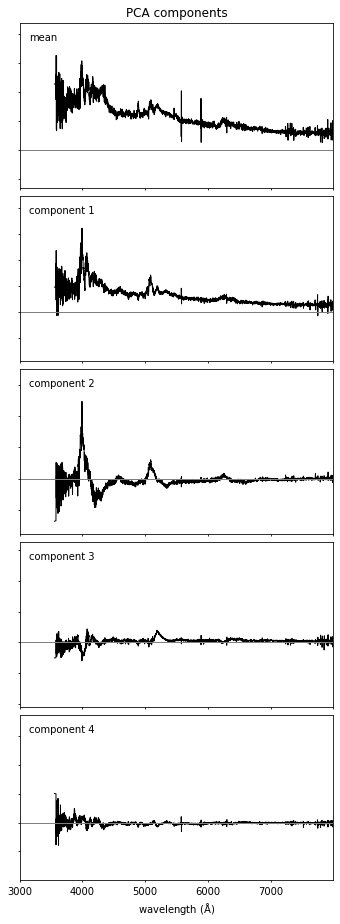

In [27]:

# Plot the results
fig = plt.figure(figsize=(15, 14))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = ['PCA components']

for i, comp in enumerate([pca_comp]):
    for j in range(n_components):
        ax = fig.add_subplot(n_components, 3, 3 * j + 1 + i)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < n_components - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            ax.xaxis.set_major_locator(
                plt.FixedLocator(list(range(3000, 7999, 1000))))
            ax.set_xlabel(r'wavelength ${\rm (\AA)}$')
        
        ax.plot(wavelengths, comp[j], '-k', lw=1)
        
        # plot zero line
        xlim = [3000, 8000]
        ax.plot(xlim, [0, 0], '-', c='gray', lw=1)

        if j == 0:
            ax.set_title(titles[i])

        if titles[i].startswith('PCA') or titles[i].startswith('ICA'):
            if j == 0:
                label = 'mean'
            else:
                label = 'component %i' % j
        else:
            label = 'component %i' % (j + 1)

        ax.text(0.03, 0.94, label, transform=ax.transAxes,
                ha='left', va='top')

        for l in ax.get_xticklines() + ax.get_yticklines():
            l.set_markersize(2)

        # adjust y limits
        ylim = plt.ylim()
        dy = 0.05 * (ylim[1] - ylim[0])

        ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)
        ax.set_xlim(xlim)
